In [2]:
### 1. Import modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### 2a. User-defined - inputs:

### Objective Function:
obj_func = 'XGBoost' # 6-D;

### Data inputs:
n_test = 50

set_seed = 888

### Student-t parameter input:
df1 = 5 # Degree(s)-of-freedom (DF)
df2 = 11 # Degree(s)-of-freedom (DF)

### Acquisition / Utility function - MLE/Type II:
util_gp = 'RegretMinimized' # Gaussian MLE
util_stp = 'tRegretMinimized' # Student-t MLE

#util_gp = 'ExpectedImprovement' # Gaussian MLE
#util_stp = 'tExpectedImprovement' # Student-t MLE

### Objective Classifier:
obj_classifier = 'binary:logistic'
#obj_classifier = 'binary:hinge'

### Probabilistic / Surrogate / Stochastic model - MLE/Type II: 
#surrogate_model_gp = 'Gaussian Process'
surrogate_model_stp = 'Student-t Process'

### Covariance Function:
cov_func = squaredExponential()
#cov_func = matern32()
#cov_func = matern52()

n_init = 5  # Number of iterations used to initialise Bayesian optimisation; minimum 2

### MLE / Type II Empirical Bayes:
optimize = False # MLE Boolean
usegrads = False # MLE Boolean (pyGPGO not programmed for Student-t MLE)


In [4]:
### 2b. User-defined - data:

### https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/home/ulsterconorc/Downloads/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [5]:
### 3. Objective Function - XGBoost Classification 6-D:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimisation
    

In [6]:
### 4a. Add new acquisition functions: add CBM & ERM (Nyugen and Osborne, 2019) method .

### Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        """
        Acquisition function class.
        Parameters
        ----------
        mode: str
            Defines the behaviour of the acquisition strategy.
        eps: float
            Small floating value to avoid `np.sqrt` or zero-division warnings.
        params: float
            Extra parameters needed for certain acquisition functions, e.g. UCB needs
            to be supplied with `beta`.
        """
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedImprovement': self.ExpectedImprovement,
            'tExpectedImprovement': self.tExpectedImprovement,
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def ExpectedImprovement(self, tau, mean, std):
        """
        Expected Improvement acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        z = (mean - tau - self.eps) / (std + self.eps)
        return (mean - tau) * norm.cdf(z) + std * norm.pdf(z)[0]


    def RegretMinimized(self, tau, mean, std):
        """
        Regret Minimized acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + std * norm.pdf(z)[0]
    
    
    def tExpectedImprovement(self, tau, mean, std, nu=3.0):
        """
        Expected Improvement acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        gamma = (mean - tau - self.eps) / (std + self.eps)
        return gamma * std * t.cdf(gamma, df=nu) + std * (1 + (gamma ** 2 - 1)/(nu - 1)) * t.pdf(gamma, df=nu)
    
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        """
        Regret Minimized acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + std * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [7]:
### 4b. Re-define tStudentProcess class with non-zero prior mean function:

### [Nyugen and Osborne, 2019] "Knowing The What But Not The Where in Bayesian Optimization"

### Inherits from class tStudentProcess()

class tStudentProcess_prior(tStudentProcess):
    def __init__(self, covfunc, nu, optimize=False, mprior=0):
        """
        t-Student Process regressor class.
        This class DOES NOT support gradients in ML estimation yet.
        Parameters
        ----------
        covfunc: instance from a class of covfunc module
            An instance from a class from the `covfunc` module.
        nu: float
            (>2.0) Degrees of freedom
        Attributes
        ----------
        covfunc: object
            Internal covariance function.
        nu: float
            Degrees of freedom.
        optimize: bool
            Whether to optimize covariance function hyperparameters.
        """
        self.covfunc = covfunc
        self.nu = nu
        self.optimize = optimize
        self.mprior = mprior
        
    def logpdf(x, nu, Sigma):
        """
        Marginal log-likelihood of a Student-t Process
        Parameters
        ----------
        x: array-like
            Point to be evaluated
        df: float
            Degrees of freedom (>2.0)
        mu: array-like
            Mean of the process.
        Sigma: array-like
            Covariance matrix of the process.
        Returns
        -------
        logp: float
            log-likelihood 
        """
        d = len(x)
        x = np.atleast_2d(x)
        xm = x - self.mprior
        V = nu * Sigma
        V_inv = np.linalg.inv(V)
        _, logdet = slogdet(np.pi * V)

        logz = -gamma(nu / 2.0 + d / 2.0) + gamma(nu / 2.0) + 0.5 * logdet
        logp = -0.5 * (nu + d) * np.log(1 + np.sum(np.dot(xm, V_inv) * xm, axis=1))

        logp = logp - logz

        return logp[0]
    
    def fit(self, X, y):
        """
        Fits a t-Student Process regressor
        Parameters
        ----------
        X: np.ndarray, shape=(nsamples, nfeatures)
            Training instances to fit the GP.
        y: np.ndarray, shape=(nsamples,)
            Corresponding continuous target values to `X`.
        """
        self.X = X
        self.y = y
        self.n1 = X.shape[0]

        if self.optimize:
            self.optHyp(param_key=self.covfunc.parameters, param_bounds=self.covfunc.bounds)

        self.K11 = self.covfunc.K(self.X, self.X)
        self.beta1 = np.dot(np.dot(self.y.T, inv(self.K11)), self.y)
        self.logp = logpdf(self.y, self.nu, mu=self.mprior, Sigma=self.K11)
        

In [8]:
### 5a. Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [9]:
### 5b. Set-seeds:

run_num_1 = 111
run_num_2 = 222
run_num_3 = 333
run_num_4 = 444
run_num_5 = 555
run_num_6 = 666
run_num_7 = 777
run_num_8 = 888
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1111
run_num_12 = 8888
run_num_13 = 1333
run_num_14 = 1444
run_num_15 = 1555
run_num_16 = 1666
run_num_17 = 1777
run_num_18 = 1888
run_num_19 = 1999
run_num_20 = 2000


In [10]:
### 6(a). Bayesian optimization runs (x20): GP run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize = optimize)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.15, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_1)
    score = np.array(cross_val_score(clf, X=X_train1, y=y_train1).mean())
    return score

gpgo_gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity1, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  0.8942284251873676 	 0.9866393347679695
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  0.8978194270778079 	 0.9866393347679695
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  0.9866393347679695 	 0.9866393347679695
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  0.9833171695772546 	 0.9866393347679695
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  0.8970080761532108 	 0.9866393347679695
1      	 [4.26395039 7.01189993 6.5300658  0.87437512 5.46993376 0.74792339]. 	  0.9793468982699757 	 0.9866393347679695
2      	 [3.78175245 7.07970621 7.28191963 0.81587231 4.93499351 0.71065767]. 	  0.9827410730465015 	 0.9866393347679695
3      	 [4.43067047 6.67488596 7.459413   0.91754713 5.28506766 0.94602244].

In [11]:
### 6(a). Bayesian optimization runs (x20): STP DF1 run number = 1

np.random.seed(run_num_1)
surrogate_stp_df1_1 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_1 = GPGO(surrogate_stp_df1_1, Acquisition_new(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  0.8942284251873676 	 0.9866393347679695
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  0.8978194270778079 	 0.9866393347679695
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  0.9866393347679695 	 0.9866393347679695
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  0.9833171695772546 	 0.9866393347679695
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  0.8970080761532108 	 0.9866393347679695
1      	 [4.2734787  7.0280739  6.52018953 0.8727775  5.47981057 0.74291623]. 	  0.9791836695033004 	 0.9866393347679695
2      	 [3.58466967 6.23229731 6.60352003 0.95553562 6.01626193 0.98701028]. 	  0.9791308608004261 	 0.9866393347679695
3      	 [4.27619005 5.89416536 6.2609122  0.90830309 5.45031527 0.78548052].

In [12]:
### 6(a). Training Regret Minimisation: run number = 1

gp_output_1 = np.append(np.max(gpgo_gp_1.GP.y[0:n_init]),gpgo_gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_1 = np.append(np.max(gpgo_stp_df1_1.GP.y[0:n_init]),gpgo_stp_df1_1.GP.y[n_init:(n_init+max_iter)])

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_df1_1 = np.log(y_global_orig - stp_df1_output_1)

train_regret_gp_1 = min_max_array(regret_gp_1)
train_regret_stp_df1_1 = min_max_array(regret_stp_df1_1)

# GP, STP df1 - training regret minimization: run number = 1
min_train_regret_gp_1 = min(train_regret_gp_1)
min_train_regret_stp_df1_1 = min(train_regret_stp_df1_1)

min_train_regret_gp_1, min_train_regret_stp_df1_1


(-5.157481542262337, -5.1287086966603415)

In [13]:
### 6(b). Bayesian optimization runs (x20): GP run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize = optimize)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.15, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_2)
    score = np.array(cross_val_score(clf, X=X_train2, y=y_train2).mean())
    return score

gpgo_gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity2, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.26028426 6.85317185 7.         0.94823061 6.         0.13331976]. 	  0.8151063793757732 	 0.985290307470739
init   	 [ 1.80155663  7.60569419 13.          0.54810697  8.          0.35874142]. 	  0.8167434741257803 	 0.985290307470739
init   	 [ 7.32780005  1.0764748   8.          0.89159454 19.          0.83473675]. 	  0.985290307470739 	 0.985290307470739
init   	 [4.68533467 8.47744556 5.         0.77589728 4.         0.9820415 ]. 	  0.9737587521793104 	 0.985290307470739
init   	 [0.64660223 1.7685673  9.         0.59891157 5.         0.42323959]. 	  0.8158601174182804 	 0.985290307470739
1      	 [4.86093057 7.98138477 5.61082137 0.82852732 4.61081523 0.72283992]. 	  0.9734178926873115 	 0.985290307470739
2      	 [4.1696363  8.00823624 5.01622419 0.96604538 4.47079443 0.66798221]. 	  0.9736387333680638 	 0.985290307470739
3      	 [4.86361472 7.65616658 5.00303193 0.99612356 4.00985553 0.70075134]. 	  0.97365313

In [14]:
### 6(b). Bayesian optimization runs (x20): STP DF1 run number = 2

np.random.seed(run_num_2)
surrogate_stp_df1_2 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_2 = GPGO(surrogate_stp_df1_2, Acquisition_new(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.26028426 6.85317185 7.         0.94823061 6.         0.13331976]. 	  0.8151063793757732 	 0.985290307470739
init   	 [ 1.80155663  7.60569419 13.          0.54810697  8.          0.35874142]. 	  0.8167434741257803 	 0.985290307470739
init   	 [ 7.32780005  1.0764748   8.          0.89159454 19.          0.83473675]. 	  0.985290307470739 	 0.985290307470739
init   	 [4.68533467 8.47744556 5.         0.77589728 4.         0.9820415 ]. 	  0.9737587521793104 	 0.985290307470739
init   	 [0.64660223 1.7685673  9.         0.59891157 5.         0.42323959]. 	  0.8158601174182804 	 0.985290307470739
1      	 [4.90951601 7.84413092 5.77979917 0.84309065 4.77980794 0.65111672]. 	  0.8116449891668037 	 0.985290307470739
2      	 [5.69694782 8.24737973 5.00827062 0.81963511 4.33214951 0.99278512]. 	  0.9733458808197558 	 0.985290307470739
3      	 [5.3250049  8.60930356 5.80333236 0.77879818 3.92640928 0.95729029]. 	  0.97376835

In [15]:
### 6(b). Training Regret Minimisation: run number = 2

gp_output_2 = np.append(np.max(gpgo_gp_2.GP.y[0:n_init]),gpgo_gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_2 = np.append(np.max(gpgo_stp_df1_2.GP.y[0:n_init]),gpgo_stp_df1_2.GP.y[n_init:(n_init+max_iter)])

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_df1_2 = np.log(y_global_orig - stp_df1_output_2)

train_regret_gp_2 = min_max_array(regret_gp_2)
train_regret_stp_df1_2 = min_max_array(regret_stp_df1_2)

# GP, STP df1- training regret minimization: run number = 2
min_train_regret_gp_2 = min(train_regret_gp_2)
min_train_regret_stp_df1_2 = min(train_regret_stp_df1_2)

min_train_regret_gp_2, min_train_regret_stp_df1_2


(-5.1078578542166415, -4.503021923520911)

In [16]:
### 6(c). Bayesian optimization runs (x20): GP run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize = optimize)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.15, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_3)
    score = np.array(cross_val_score(clf, X=X_train3, y=y_train3).mean())
    return score

gpgo_gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity3, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.43291087  7.28950728  8.          0.66640751 15.          0.43184964]. 	  0.9065377491537258 	 0.9901631579395763
init   	 [ 0.48303666  1.04530188 11.          0.98399654 13.          0.62888345]. 	  0.9046558247711304 	 0.9901631579395763
init   	 [ 9.6557048   4.68513871 10.          0.6018496   9.          0.12912301]. 	  0.9074066957437422 	 0.9901631579395763
init   	 [ 3.2007756   5.90000752 14.          0.9799891   4.          0.75368544]. 	  0.9901631579395763 	 0.9901631579395763
init   	 [ 4.84228675  1.26861034 13.          0.86540685 17.          0.98837363]. 	  0.9896014694519493 	 0.9901631579395763
1      	 [ 2.83918184  6.44340525 14.27805963  1.          3.44389232  0.77426256]. 	  0.991656188575034 	 0.991656188575034
2      	 [ 3.30787206  6.72177194 14.29223823  0.99945053  4.14598392  0.75044251]. 	  0.9900527405032052 	 0.991656188575034
3      	 [ 3.68566625  6.38891902 14.07103318  0.9919019

In [17]:
### 6(c). Bayesian optimization runs (x20): STP DF1 run number = 3

np.random.seed(run_num_3)
surrogate_stp_df1_3 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_3 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.43291087  7.28950728  8.          0.66640751 15.          0.43184964]. 	  0.9065377491537258 	 0.9901631579395763
init   	 [ 0.48303666  1.04530188 11.          0.98399654 13.          0.62888345]. 	  0.9046558247711304 	 0.9901631579395763
init   	 [ 9.6557048   4.68513871 10.          0.6018496   9.          0.12912301]. 	  0.9074066957437422 	 0.9901631579395763
init   	 [ 3.2007756   5.90000752 14.          0.9799891   4.          0.75368544]. 	  0.9901631579395763 	 0.9901631579395763
init   	 [ 4.84228675  1.26861034 13.          0.86540685 17.          0.98837363]. 	  0.9896014694519493 	 0.9901631579395763
1      	 [ 2.52597163  6.29929221 14.00000036  0.5         4.00000036  0.1       ]. 	  0.9054623625279173 	 0.9901631579395763
2      	 [ 2.89470865  6.0172221  14.96146823  0.74353917  4.00000003  0.47834438]. 	  0.9057167985828637 	 0.9901631579395763
3      	 [ 3.29408862  6.62168792 14.30589426  0.7750

In [18]:
### 6(c). Training Regret Minimisation: run number = 3

gp_output_3 = np.append(np.max(gpgo_gp_3.GP.y[0:n_init]),gpgo_gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_3 = np.append(np.max(gpgo_stp_df1_3.GP.y[0:n_init]),gpgo_stp_df1_3.GP.y[n_init:(n_init+max_iter)])

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_df1_3 = np.log(y_global_orig - stp_df1_output_3)

train_regret_gp_3 = min_max_array(regret_gp_3)
train_regret_stp_df1_3 = min_max_array(regret_stp_df1_3)

# GP, STP df1 - training regret minimization: run number = 3
min_train_regret_gp_3 = min(train_regret_gp_3)
min_train_regret_stp_df1_3 = min(train_regret_stp_df1_3)

min_train_regret_gp_3, min_train_regret_stp_df1_3


(-5.362238766542459, -5.359172434222741)

In [19]:
### 6(d). Bayesian optimization runs (x20): GP run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize = optimize)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.15, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_4)
    score = np.array(cross_val_score(clf, X=X_train4, y=y_train4).mean())
    return score

gpgo_gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity4, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.39361047  8.21294965  8.          0.78209507 13.          0.13522592]. 	  0.8347415658712235 	 0.9926499150795474
init   	 [ 0.65672388  2.7650064   7.          0.85261754 13.          0.71765519]. 	  0.9917329695663795 	 0.9926499150795474
init   	 [ 7.14863772  5.28551197 11.          0.74670457  4.          0.21785319]. 	  0.8357065202641044 	 0.9926499150795474
init   	 [3.48953944 9.17796441 8.         0.54726456 8.         0.57654823]. 	  0.834251863599193 	 0.9926499150795474
init   	 [ 3.03907726  6.22312661 14.          0.97978402  3.          0.96911775]. 	  0.9926499150795474 	 0.9926499150795474
1      	 [ 3.73269969  6.05945236 13.49455955  0.9399098   3.16473106  0.84137088]. 	  0.9925682997627786 	 0.9926499150795474
2      	 [ 3.11946485  6.26532907 13.53703995  0.941204    3.75068206  1.        ]. 	  0.9969322797140739 	 0.9969322797140739
3      	 [ 3.63473624  6.23056588 14.22444083  1.          3

In [20]:
### 6(d). Bayesian optimization runs (x20): STP DF1 run number = 4

np.random.seed(run_num_4)
surrogate_stp_df1_4 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_4 = GPGO(surrogate_stp_df1_4, Acquisition_new(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.39361047  8.21294965  8.          0.78209507 13.          0.13522592]. 	  0.8347415658712235 	 0.9926499150795474
init   	 [ 0.65672388  2.7650064   7.          0.85261754 13.          0.71765519]. 	  0.9917329695663795 	 0.9926499150795474
init   	 [ 7.14863772  5.28551197 11.          0.74670457  4.          0.21785319]. 	  0.8357065202641044 	 0.9926499150795474
init   	 [3.48953944 9.17796441 8.         0.54726456 8.         0.57654823]. 	  0.834251863599193 	 0.9926499150795474
init   	 [ 3.03907726  6.22312661 14.          0.97978402  3.          0.96911775]. 	  0.9926499150795474 	 0.9926499150795474
1      	 [ 3.89816267  6.02498016 13.37367365  0.93104749  3.20726584  0.81173586]. 	  0.9925106901304365 	 0.9926499150795474
2      	 [ 3.15634102  6.27063233 13.44400788  0.93412892  3.88151037  1.        ]. 	  0.9968698685299898 	 0.9968698685299898
3      	 [ 3.41840637  6.88246362 13.36243828  0.9998242   3

In [21]:
### 6(d). Training Regret Minimisation: run number = 4

gp_output_4 = np.append(np.max(gpgo_gp_4.GP.y[0:n_init]),gpgo_gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_4 = np.append(np.max(gpgo_stp_df1_4.GP.y[0:n_init]),gpgo_stp_df1_4.GP.y[n_init:(n_init+max_iter)])

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_df1_4 = np.log(y_global_orig - stp_df1_output_4)

train_regret_gp_4 = min_max_array(regret_gp_4)
train_regret_stp_df1_4 = min_max_array(regret_stp_df1_4)

# GP, STP df1 - training regret minimization: run number = 4
min_train_regret_gp_4 = min(train_regret_gp_4)
min_train_regret_stp_df1_4 = min(train_regret_stp_df1_4)

min_train_regret_gp_4, min_train_regret_stp_df1_4


(-5.917002476917337, -5.871699927585947)

In [22]:
### 6(e). Bayesian optimization runs (x20): GP run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize = optimize)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.15, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_5)
    score = np.array(cross_val_score(clf, X=X_train5, y=y_train5).mean())
    return score


gpgo_gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity5, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.17834087  0.47855133  9.          0.99615185 10.          0.90306432]. 	  0.9946519027322408 	 0.9952231976422058
init   	 [ 6.77503421  3.3973338  11.          0.81021773 17.          0.81898565]. 	  0.9950935800834317 	 0.9952231976422058
init   	 [0.22674351 6.47067187 9.         0.77223434 4.         0.60667042]. 	  0.7947747619154123 	 0.9952231976422058
init   	 [ 2.06334907  5.19016261  9.          0.80805327 18.          0.67462476]. 	  0.9952231976422058 	 0.9952231976422058
init   	 [ 7.19469073  7.30014235  6.          0.71569795 12.          0.66615557]. 	  0.788961048818825 	 0.9952231976422058
1      	 [ 2.46652882  4.47984721  8.64346559  0.85798734 17.99984352  0.59924168]. 	  0.7934929837920489 	 0.9952231976422058
2      	 [ 2.31036503  4.99682792  9.20489112  0.79903804 17.20152528  0.52688047]. 	  0.7952596500517135 	 0.9952231976422058
3      	 [ 2.48116955  4.88728985  9.64365037  0.79988781 18

In [23]:
### 6(e). Bayesian optimization runs (x20): STP DF1 run number = 5

np.random.seed(run_num_5)
surrogate_stp_df1_5 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_5 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.17834087  0.47855133  9.          0.99615185 10.          0.90306432]. 	  0.9946519027322408 	 0.9952231976422058
init   	 [ 6.77503421  3.3973338  11.          0.81021773 17.          0.81898565]. 	  0.9950935800834317 	 0.9952231976422058
init   	 [0.22674351 6.47067187 9.         0.77223434 4.         0.60667042]. 	  0.7947747619154123 	 0.9952231976422058
init   	 [ 2.06334907  5.19016261  9.          0.80805327 18.          0.67462476]. 	  0.9952231976422058 	 0.9952231976422058
init   	 [ 7.19469073  7.30014235  6.          0.71569795 12.          0.66615557]. 	  0.788961048818825 	 0.9952231976422058
1      	 [ 2.56527142  4.30553457  8.55581752  0.87024749 17.99985683  0.58072488]. 	  0.793483381933135 	 0.9952231976422058
2      	 [ 2.4083359   4.86359044  9.18778705  0.80487503 17.06994923  0.49196723]. 	  0.7950244080346048 	 0.9952231976422058
3      	 [ 2.99657294  5.18882545  9.24474937  0.78782127 18.

In [24]:
### 6(e). Training Regret Minimisation: run number = 5

gp_output_5 = np.append(np.max(gpgo_gp_5.GP.y[0:n_init]),gpgo_gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_5 = np.append(np.max(gpgo_stp_df1_5.GP.y[0:n_init]),gpgo_stp_df1_5.GP.y[n_init:(n_init+max_iter)])

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_df1_5 = np.log(y_global_orig - stp_df1_output_5)

train_regret_gp_5 = min_max_array(regret_gp_5)
train_regret_stp_df1_5 = min_max_array(regret_stp_df1_5)

# GP, STP df1 - training regret minimization: run number = 5
min_train_regret_gp_5 = min(train_regret_gp_5)
min_train_regret_stp_df1_5 = min(train_regret_stp_df1_5)

min_train_regret_gp_5, min_train_regret_stp_df1_5


(-5.38083447122454, -5.510944372658239)

In [25]:
### 6(f). Bayesian optimization runs (x20): GP run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize = optimize)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.15, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_6)
    score = np.array(cross_val_score(clf, X=X_train6, y=y_train6).mean())
    return score

gpgo_gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity6, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.00437122  8.44186643 11.          0.86392903  5.          0.40237152]. 	  0.8417892131861526 	 0.9902303948753781
init   	 [ 2.44342852  2.59875544  6.          0.75403315 15.          0.79035779]. 	  0.9902303948753781 	 0.9902303948753781
init   	 [ 8.19956557  3.97476246 10.          0.57775603 12.          0.10459795]. 	  0.8423221084044542 	 0.9902303948753781
init   	 [1.12857654 1.10953672 5.         0.92389099 6.         0.93150723]. 	  0.984248594694138 	 0.9902303948753781
init   	 [2.94894531 5.24380613 5.         0.62956592 7.         0.34881625]. 	  0.8346696302681474 	 0.9902303948753781
1      	 [ 2.07484791  2.26706386  5.37466561  0.73884936 14.58344115  0.84152118]. 	  0.9840949574840945 	 0.9902303948753781
2      	 [ 2.18736441  3.13572509  5.39376544  0.73528334 14.73962994  0.71832142]. 	  0.9831876056709915 	 0.9902303948753781
3      	 [ 2.60768516  2.70095971  5.74322957  0.7280191  14.18358

In [26]:
### 6(f). Bayesian optimization runs (x20): STP DF1 run number = 6

np.random.seed(run_num_6)
surrogate_stp_df1_6 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_6 = GPGO(surrogate_stp_df1_6, Acquisition_new(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.00437122  8.44186643 11.          0.86392903  5.          0.40237152]. 	  0.8417892131861526 	 0.9902303948753781
init   	 [ 2.44342852  2.59875544  6.          0.75403315 15.          0.79035779]. 	  0.9902303948753781 	 0.9902303948753781
init   	 [ 8.19956557  3.97476246 10.          0.57775603 12.          0.10459795]. 	  0.8423221084044542 	 0.9902303948753781
init   	 [1.12857654 1.10953672 5.         0.92389099 6.         0.93150723]. 	  0.984248594694138 	 0.9902303948753781
init   	 [2.94894531 5.24380613 5.         0.62956592 7.         0.34881625]. 	  0.8346696302681474 	 0.9902303948753781
1      	 [ 1.88295477  1.89414643  6.28043772  0.68711924 14.4387337   0.98011809]. 	  0.9901775891456329 	 0.9902303948753781
2      	 [ 2.07843536  1.95180503  5.42270936  0.90672359 14.66062332  0.49282597]. 	  0.8339686987159993 	 0.9902303948753781
3      	 [ 2.84846895  1.99012602  6.20287372  0.87662836 14.32777

In [27]:
### 6(f). Training Regret Minimisation: run number = 6

gp_output_6 = np.append(np.max(gpgo_gp_6.GP.y[0:n_init]),gpgo_gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_6 = np.append(np.max(gpgo_stp_df1_6.GP.y[0:n_init]),gpgo_stp_df1_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_df1_6 = np.log(y_global_orig - stp_df1_output_6)

train_regret_gp_6 = min_max_array(regret_gp_6)
train_regret_stp_df1_6 = min_max_array(regret_stp_df1_6)

# GP, STP df1 - training regret minimization: run number = 6
min_train_regret_gp_6 = min(train_regret_gp_6)
min_train_regret_stp_df1_6 = min(train_regret_stp_df1_6)

min_train_regret_gp_6, min_train_regret_stp_df1_6


(-4.993254051620601, -5.024158361885674)

In [28]:
### 6(g). Bayesian optimization runs (x20): GP run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize = optimize)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=0.15, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_7)
    score = np.array(cross_val_score(clf, X=X_train7, y=y_train7).mean())
    return score

gpgo_gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity7, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.52663735  3.0235661  12.          0.81812715  8.          0.65052854]. 	  0.8560769562555897 	 0.9892990896497961
init   	 [ 7.5633323   8.82772753  5.          0.54668663 19.          0.56839702]. 	  0.8563649518687818 	 0.9892990896497961
init   	 [ 3.86398258  9.70445521 12.          0.8132366  19.          0.9367083 ]. 	  0.9892990896497961 	 0.9892990896497961
init   	 [8.12320793 1.19710634 7.         0.61146405 8.         0.3000627 ]. 	  0.8537726141070033 	 0.9892990896497961
init   	 [ 5.5087939   2.19588947  7.          0.94140422 14.          0.14184967]. 	  0.8533213263231928 	 0.9892990896497961
1      	 [ 3.13025235  9.32150908 12.24262115  0.81419842 18.75733823  0.82462765]. 	  0.9895871385029347 	 0.9895871385029347
2      	 [ 3.88821205  9.19710197 12.24260801  0.71936385 18.31700479  0.87485881]. 	  0.9887565987954314 	 0.9895871385029347
3      	 [ 3.5897047   9.89804462 12.65272789  0.75167846 1

In [29]:
### 6(g). Bayesian optimization runs (x20): STP DF1 run number = 7

np.random.seed(run_num_7)
surrogate_stp_df1_7 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_7 = GPGO(surrogate_stp_df1_7, Acquisition_new(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.52663735  3.0235661  12.          0.81812715  8.          0.65052854]. 	  0.8560769562555897 	 0.9892990896497961
init   	 [ 7.5633323   8.82772753  5.          0.54668663 19.          0.56839702]. 	  0.8563649518687818 	 0.9892990896497961
init   	 [ 3.86398258  9.70445521 12.          0.8132366  19.          0.9367083 ]. 	  0.9892990896497961 	 0.9892990896497961
init   	 [8.12320793 1.19710634 7.         0.61146405 8.         0.3000627 ]. 	  0.8537726141070033 	 0.9892990896497961
init   	 [ 5.5087939   2.19588947  7.          0.94140422 14.          0.14184967]. 	  0.8533213263231928 	 0.9892990896497961
1      	 [ 2.96119506  9.23321774 12.29853838  0.81439348 18.70143946  0.79881784]. 	  0.9896063419441914 	 0.9896063419441914
2      	 [ 3.7030148   9.04206623 11.75712403  0.80998932 18.47504277  0.3868791 ]. 	  0.8529996992432557 	 0.9896063419441914
3      	 [ 3.73825922  9.49179546 12.58906372  0.82112166 1

In [30]:
### 6(g). Training Regret Minimisation: run number = 7

gp_output_7 = np.append(np.max(gpgo_gp_7.GP.y[0:n_init]),gpgo_gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_7 = np.append(np.max(gpgo_stp_df1_7.GP.y[0:n_init]),gpgo_stp_df1_7.GP.y[n_init:(n_init+max_iter)])

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_df1_7 = np.log(y_global_orig - stp_df1_output_7)

train_regret_gp_7 = min_max_array(regret_gp_7)
train_regret_stp_df1_7 = min_max_array(regret_stp_df1_7)

# GP, STP df1 - training regret minimization: run number = 7
min_train_regret_gp_7 = min(train_regret_gp_7)
min_train_regret_stp_df1_7 = min(train_regret_stp_df1_7)

min_train_regret_gp_7, min_train_regret_stp_df1_7

(-5.344989113198684, -5.513324505293958)

In [31]:
### 6(h). Bayesian optimization runs (x20): GP run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize = optimize)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=0.15, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_8)
    score = np.array(cross_val_score(clf, X=X_train8, y=y_train8).mean())
    return score

gpgo_gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity8, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.59560606  1.64569495 11.          0.89021195 15.          0.4857008 ]. 	  0.8866767704430721 	 0.9915505688196039
init   	 [ 0.57460093  9.25007434  5.          0.56647642 17.          0.7533211 ]. 	  0.9812288212003665 	 0.9915505688196039
init   	 [1.90674396 4.32019547 9.         0.93708225 3.         0.91775905]. 	  0.9915505688196039 	 0.9915505688196039
init   	 [ 0.36770475  8.43368681 14.          0.6826844  15.          0.6291966 ]. 	  0.8877377519986741 	 0.9915505688196039
init   	 [ 5.33840324  0.449182   14.          0.52045439  2.          0.48604556]. 	  0.8862014953669619 	 0.9915505688196039
1      	 [1.76658979 4.32144428 9.8843894  0.97991169 2.99999998 1.        ]. 	  0.995847296208214 	 0.995847296208214
2      	 [1.89709294 4.03023869 9.4791362  0.87197605 3.67049712 0.76666055]. 	  0.9915505691653229 	 0.995847296208214
3      	 [2.06515989 3.60289567 9.4784739  1.         2.96420198 1.       

In [32]:
### 6(h). Bayesian optimization runs (x20): STP DF1 run number = 8

np.random.seed(run_num_8)
surrogate_stp_df1_8 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_8 = GPGO(surrogate_stp_df1_8, Acquisition_new(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.59560606  1.64569495 11.          0.89021195 15.          0.4857008 ]. 	  0.8866767704430721 	 0.9915505688196039
init   	 [ 0.57460093  9.25007434  5.          0.56647642 17.          0.7533211 ]. 	  0.9812288212003665 	 0.9915505688196039
init   	 [1.90674396 4.32019547 9.         0.93708225 3.         0.91775905]. 	  0.9915505688196039 	 0.9915505688196039
init   	 [ 0.36770475  8.43368681 14.          0.6826844  15.          0.6291966 ]. 	  0.8877377519986741 	 0.9915505688196039
init   	 [ 5.33840324  0.449182   14.          0.52045439  2.          0.48604556]. 	  0.8862014953669619 	 0.9915505688196039
1      	 [1.84479639 4.30796743 9.78796116 1.         2.20977516 1.        ]. 	  0.9957704817517494 	 0.9957704817517494
2      	 [ 1.80704489  4.45026773 10.01104732  0.85803542  3.18517512  0.72712717]. 	  0.9916465861641749 	 0.9957704817517494
3      	 [2.2245225  3.6719132  9.70131485 0.98798209 2.88877069 

In [33]:
### 6(h). Training Regret Minimisation: run number = 8

gp_output_8 = np.append(np.max(gpgo_gp_8.GP.y[0:n_init]),gpgo_gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_8 = np.append(np.max(gpgo_stp_df1_8.GP.y[0:n_init]),gpgo_stp_df1_8.GP.y[n_init:(n_init+max_iter)])

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_df1_8 = np.log(y_global_orig - stp_df1_output_8)

train_regret_gp_8 = min_max_array(regret_gp_8)
train_regret_stp_df1_8 = min_max_array(regret_stp_df1_8)

# GP, STP df1 - training regret minimization: run number = 8
min_train_regret_gp_8 = min(train_regret_gp_8)
min_train_regret_stp_df1_8 = min(train_regret_stp_df1_8)

min_train_regret_gp_8, min_train_regret_stp_df1_8

(-5.7978351681019, -5.499138667834888)

In [34]:
### 6(i). Bayesian optimization runs (x20): GP run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize = optimize)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=0.15, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_9)
    score = np.array(cross_val_score(clf, X=X_train9, y=y_train9).mean())
    return score

gpgo_gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity9, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.0342804   5.27522296 13.          0.60741904 17.          0.15336222]. 	  0.8605604646092962 	 0.8631049071619116
init   	 [7.56063644 1.79876369 7.         0.84869647 5.         0.55956942]. 	  0.8608005020243582 	 0.8631049071619116
init   	 [2.43675539 0.20225128 6.         0.51669963 7.         0.4646446 ]. 	  0.8615638388834549 	 0.8631049071619116
init   	 [ 7.6043547   4.73758376  9.          0.87564624 15.          0.65751286]. 	  0.8622551547480161 	 0.8631049071619116
init   	 [ 4.70349314  6.71029586  6.          0.97680389 11.          0.41971652]. 	  0.8631049071619116 	 0.8631049071619116
1      	 [ 7.70430466  4.86261386  9.93007208  0.81326555 15.46507804  0.54026015]. 	  0.8614438159927249 	 0.8631049071619116
2      	 [ 7.46572015  5.51114961  9.62961201  0.81074992 14.73805026  0.57529175]. 	  0.8614294136192138 	 0.8631049071619116
3      	 [ 7.37582936  4.52172086  9.86019733  0.79186538 14.5387

In [35]:
### 6(i). Bayesian optimization runs (x20): STP DF1 run number = 9

np.random.seed(run_num_9)
surrogate_stp_df1_9 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_9 = GPGO(surrogate_stp_df1_9, Acquisition_new(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.0342804   5.27522296 13.          0.60741904 17.          0.15336222]. 	  0.8605604646092962 	 0.8631049071619116
init   	 [7.56063644 1.79876369 7.         0.84869647 5.         0.55956942]. 	  0.8608005020243582 	 0.8631049071619116
init   	 [2.43675539 0.20225128 6.         0.51669963 7.         0.4646446 ]. 	  0.8615638388834549 	 0.8631049071619116
init   	 [ 7.6043547   4.73758376  9.          0.87564624 15.          0.65751286]. 	  0.8622551547480161 	 0.8631049071619116
init   	 [ 4.70349314  6.71029586  6.          0.97680389 11.          0.41971652]. 	  0.8631049071619116 	 0.8631049071619116
1      	 [ 7.72344127  4.88657408 10.10856216  0.80128598 15.55423503  0.51778829]. 	  0.8613814025960397 	 0.8631049071619116
2      	 [ 8.65074969  4.89216486  9.35697903  0.85305425 15.41198067  0.50098839]. 	  0.8610597536671071 	 0.8631049071619116
3      	 [ 7.75885712  5.42891486  9.13881871  0.77046553 15.8354

In [36]:
### 6(i). Training Regret Minimisation: run number = 9

gp_output_9 = np.append(np.max(gpgo_gp_9.GP.y[0:n_init]),gpgo_gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_9 = np.append(np.max(gpgo_stp_df1_9.GP.y[0:n_init]),gpgo_stp_df1_9.GP.y[n_init:(n_init+max_iter)])

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_df1_9 = np.log(y_global_orig - stp_df1_output_9)

train_regret_gp_9 = min_max_array(regret_gp_9)
train_regret_stp_df1_9 = min_max_array(regret_stp_df1_9)

# GP, STP df1 - training regret minimization: run number = 9
min_train_regret_gp_9 = min(train_regret_gp_9)
min_train_regret_stp_df1_9 = min(train_regret_stp_df1_9)

min_train_regret_gp_9, min_train_regret_stp_df1_9

(-5.341974303811602, -5.348010641468211)

In [37]:
### 6(j). Bayesian optimization runs (x20): GP run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize = optimize)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=0.15, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_10)
    score = np.array(cross_val_score(clf, X=X_train10, y=y_train10).mean())
    return score

gpgo_gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity10, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  0.8645259990834046 	 0.9889005473743276
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  0.8644203854114204 	 0.9889005473743276
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  0.8649820882116354 	 0.9889005473743276
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  0.9889005473743276 	 0.9889005473743276
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  0.8641707475203182 	 0.9889005473743276
1      	 [ 9.9991147   3.05308212  8.50496277  0.8800611  19.64020102  0.82679794]. 	  0.9873738932929689 	 0.9889005473743276
2      	 [ 9.24077056  3.01174943  8.47971536  0.86287492 19.17007918  0.78860799]. 	  0.987580328143021 	 0.9889005473743276
3      	 [ 9.80870086  3.59723578  8.15443941  0.94261

In [38]:
### 6(j). Bayesian optimization runs (x20): STP DF1 run number = 10

np.random.seed(run_num_10)
surrogate_stp_df1_10 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_10 = GPGO(surrogate_stp_df1_10, Acquisition_new(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  0.8645259990834046 	 0.9889005473743276
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  0.8644203854114204 	 0.9889005473743276
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  0.8649820882116354 	 0.9889005473743276
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  0.9889005473743276 	 0.9889005473743276
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  0.8641707475203182 	 0.9889005473743276
1      	 [ 9.04745562  3.64684796  9.54823628  0.71322876 18.47622091  0.89962056]. 	  0.9891165814558316 	 0.9891165814558316
2      	 [ 8.9123309   2.86940405  9.06377418  0.77671027 18.9721954   0.90632098]. 	  0.9889341531890955 	 0.9891165814558316
3      	 [ 9.27440234  3.28611076  8.67821898  0.8054

In [39]:
### 6(j). Training Regret Minimisation: run number = 10

gp_output_10 = np.append(np.max(gpgo_gp_10.GP.y[0:n_init]),gpgo_gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_10 = np.append(np.max(gpgo_stp_df1_10.GP.y[0:n_init]),gpgo_stp_df1_10.GP.y[n_init:(n_init+max_iter)])

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_df1_10 = np.log(y_global_orig - stp_df1_output_10)

train_regret_gp_10 = min_max_array(regret_gp_10)
train_regret_stp_df1_10 = min_max_array(regret_stp_df1_10)

# GP, STP df1 - training regret minimization: run number = 10
min_train_regret_gp_10 = min(train_regret_gp_10)
min_train_regret_stp_df1_10 = min(train_regret_stp_df1_10)

min_train_regret_gp_10, min_train_regret_stp_df1_10

(-5.163337423675783, -5.249129683335651)

In [40]:
### 6(k). Bayesian optimization runs (x20): GP run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize = optimize)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=0.15, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_11)
    score = np.array(cross_val_score(clf, X=X_train11, y=y_train11).mean())
    return score

gpgo_gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity11, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.95549199  9.25003702  7.          0.65523847 12.          0.6729611 ]. 	  0.992957199871945 	 0.9942534235137975
init   	 [ 4.16869519  5.05504008 11.          0.89221267 11.          0.51950888]. 	  0.880037272658953 	 0.9942534235137975
init   	 [ 2.37132124  4.35159182 13.          0.51218474 19.          0.43481903]. 	  0.8796339992862624 	 0.9942534235137975
init   	 [5.24304212 1.64265056 6.         0.81868728 1.         0.9370167 ]. 	  0.9912097053172655 	 0.9942534235137975
init   	 [ 8.16499915  7.69424925 10.          0.64918107 19.          0.99719505]. 	  0.9942534235137975 	 0.9942534235137975
1      	 [ 8.271983    7.77290851  9.38377945  0.64633445 18.38377945  0.83165214]. 	  0.9935813059047091 	 0.9942534235137975
2      	 [ 8.17970274  7.13182723  9.98609862  0.67636247 18.3315249   0.85327987]. 	  0.9938213451866532 	 0.9942534235137975
3      	 [ 7.72630198  7.23998797  9.42048224  0.62802282 18.

In [41]:
### 6(k). Bayesian optimization runs (x20): STP DF1 run number = 11

np.random.seed(run_num_11)
surrogate_stp_df1_11 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_11 = GPGO(surrogate_stp_df1_11, Acquisition_new(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.95549199  9.25003702  7.          0.65523847 12.          0.6729611 ]. 	  0.992957199871945 	 0.9942534235137975
init   	 [ 4.16869519  5.05504008 11.          0.89221267 11.          0.51950888]. 	  0.880037272658953 	 0.9942534235137975
init   	 [ 2.37132124  4.35159182 13.          0.51218474 19.          0.43481903]. 	  0.8796339992862624 	 0.9942534235137975
init   	 [5.24304212 1.64265056 6.         0.81868728 1.         0.9370167 ]. 	  0.9912097053172655 	 0.9942534235137975
init   	 [ 8.16499915  7.69424925 10.          0.64918107 19.          0.99719505]. 	  0.9942534235137975 	 0.9942534235137975
1      	 [ 7.67502557  7.91440707 10.9300382   0.61722977 18.69001465  0.86427173]. 	  0.9940517892474846 	 0.9942534235137975
2      	 [ 7.66349604  6.97087878 10.44213859  0.65996873 18.61556039  0.86594976]. 	  0.9941814101942223 	 0.9942534235137975
3      	 [ 7.25016945  7.59926338 10.29436085  0.61576103 19.

In [42]:
### 6(k). Training Regret Minimisation: run number = 11

gp_output_11 = np.append(np.max(gpgo_gp_11.GP.y[0:n_init]),gpgo_gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_11 = np.append(np.max(gpgo_stp_df1_11.GP.y[0:n_init]),gpgo_stp_df1_11.GP.y[n_init:(n_init+max_iter)])

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_df1_11 = np.log(y_global_orig - stp_df1_output_11)

train_regret_gp_11 = min_max_array(regret_gp_11)
train_regret_stp_df1_11 = min_max_array(regret_stp_df1_11)

# GP, STP df1 - training regret minimization: run number = 11
min_train_regret_gp_11 = min(train_regret_gp_11)
min_train_regret_stp_df1_11 = min(train_regret_stp_df1_11)

min_train_regret_gp_11, min_train_regret_stp_df1_11

(-5.297827683516764, -5.286376166911191)

In [43]:
### 6(l). Bayesian optimization runs (x20): GP run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize = optimize)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=0.15, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_12)
    score = np.array(cross_val_score(clf, X=X_train12, y=y_train12).mean())
    return score


gpgo_gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity12, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.6238432   6.94220364 14.          0.60068848 17.          0.64107078]. 	  0.8573627321615301 	 0.9771961242579525
init   	 [ 9.70248741  2.88838338 11.          0.56945199 12.          0.62104197]. 	  0.856993066332202 	 0.9771961242579525
init   	 [8.90655999 3.53839188 8.         0.98537995 1.         0.66949383]. 	  0.9752517909732029 	 0.9771961242579525
init   	 [ 7.3853305   5.34255009 10.          0.90708741 18.          0.78973723]. 	  0.9771961242579525 	 0.9771961242579525
init   	 [ 5.65590842  1.36833384 10.          0.86793408 17.          0.47248995]. 	  0.8570890771772571 	 0.9771961242579525
1      	 [ 7.02707205  4.51901425 10.00018655  0.89901162 17.79271223  0.72399773]. 	  0.9773257463109908 	 0.9773257463109908
2      	 [ 6.97656902  4.85423633 10.28145084  0.87887616 18.58050551  0.8217898 ]. 	  0.9772489329608266 	 0.9773257463109908
3      	 [ 7.39940505  4.84102929 10.73915643  0.82971804 17

In [44]:
### 6(l). Bayesian optimization runs (x20): STP DF1 run number = 12

np.random.seed(run_num_12)
surrogate_stp_df1_12 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_12 = GPGO(surrogate_stp_df1_12, Acquisition_new(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.6238432   6.94220364 14.          0.60068848 17.          0.64107078]. 	  0.8573627321615301 	 0.9771961242579525
init   	 [ 9.70248741  2.88838338 11.          0.56945199 12.          0.62104197]. 	  0.856993066332202 	 0.9771961242579525
init   	 [8.90655999 3.53839188 8.         0.98537995 1.         0.66949383]. 	  0.9752517909732029 	 0.9771961242579525
init   	 [ 7.3853305   5.34255009 10.          0.90708741 18.          0.78973723]. 	  0.9771961242579525 	 0.9771961242579525
init   	 [ 5.65590842  1.36833384 10.          0.86793408 17.          0.47248995]. 	  0.8570890771772571 	 0.9771961242579525
1      	 [ 6.94089072  4.32145209 10.00010209  0.89699567 17.74305067  0.70820354]. 	  0.9773161425851926 	 0.9773161425851926
2      	 [ 7.45954075  4.91229848  9.72219475  0.9221859  17.06663999  0.68151234]. 	  0.9768552676008486 	 0.9773161425851926
3      	 [ 7.57226192  4.75939567 10.63291074  0.85026463 17

In [45]:
### 6(l). Training Regret Minimisation: run number = 12

gp_output_12 = np.append(np.max(gpgo_gp_12.GP.y[0:n_init]),gpgo_gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_12 = np.append(np.max(gpgo_stp_df1_12.GP.y[0:n_init]),gpgo_stp_df1_12.GP.y[n_init:(n_init+max_iter)])

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_df1_12 = np.log(y_global_orig - stp_df1_output_12)

train_regret_gp_12 = min_max_array(regret_gp_12)
train_regret_stp_df1_12 = min_max_array(regret_stp_df1_12)

# GP, STP df1 - training regret minimization: run number = 12
min_train_regret_gp_12 = min(train_regret_gp_12)
min_train_regret_stp_df1_12 = min(train_regret_stp_df1_12)

min_train_regret_gp_12, min_train_regret_stp_df1_12

(-5.379791996203266, -5.308440173741311)

In [46]:
### 6(m). Bayesian optimization runs (x20): GP run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize = optimize)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=0.15, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_13)
    score = np.array(cross_val_score(clf, X=X_train13, y=y_train13).mean())
    return score


gpgo_gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity13, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.99585426  0.12569841 12.          0.92487106 14.          0.12066157]. 	  0.8956879389264313 	 0.9851511111471544
init   	 [5.48040248 5.46008077 7.         0.70510802 9.         0.68228527]. 	  0.9851511111471544 	 0.9851511111471544
init   	 [ 8.36045309  6.9875368  14.          0.56453019 16.          0.1837942 ]. 	  0.8951454426097993 	 0.9851511111471544
init   	 [6.0919376  3.49625894 6.         0.83970528 4.         0.9658705 ]. 	  0.9822226212039785 	 0.9851511111471544
init   	 [ 4.66489813  6.85692341  9.          0.96730546 13.          0.54391367]. 	  0.896979361500538 	 0.9851511111471544
1      	 [5.32462041 5.72693227 7.38207785 0.75519582 9.76414294 0.65584904]. 	  0.8948285896319724 	 0.9851511111471544
2      	 [4.93566025 5.72647211 7.65581821 0.75839908 8.88083174 0.69646712]. 	  0.9852903364419842 	 0.9852903364419842
3      	 [5.71763045 5.39736335 7.85597572 0.70334811 9.05584498 0.61388286]. 

In [47]:
### 6(m). Bayesian optimization runs (x20): STP DF1 run number = 13

np.random.seed(run_num_13)
surrogate_stp_df1_13 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_13 = GPGO(surrogate_stp_df1_13, Acquisition_new(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.99585426  0.12569841 12.          0.92487106 14.          0.12066157]. 	  0.8956879389264313 	 0.9851511111471544
init   	 [5.48040248 5.46008077 7.         0.70510802 9.         0.68228527]. 	  0.9851511111471544 	 0.9851511111471544
init   	 [ 8.36045309  6.9875368  14.          0.56453019 16.          0.1837942 ]. 	  0.8951454426097993 	 0.9851511111471544
init   	 [6.0919376  3.49625894 6.         0.83970528 4.         0.9658705 ]. 	  0.9822226212039785 	 0.9851511111471544
init   	 [ 4.66489813  6.85692341  9.          0.96730546 13.          0.54391367]. 	  0.896979361500538 	 0.9851511111471544
1      	 [5.2858694  5.79307474 7.47696861 0.76763618 9.95391324 0.64930613]. 	  0.894660559382689 	 0.9851511111471544
2      	 [5.83488294 5.95850669 7.89055394 0.67018426 9.0281957  0.62837054]. 	  0.8960383959904314 	 0.9851511111471544
3      	 [5.88138594 6.30019362 6.914094   0.5959849  9.4189374  0.8430745 ]. 	

In [48]:
### 6(m). Training Regret Minimisation: run number = 13

gp_output_13 = np.append(np.max(gpgo_gp_13.GP.y[0:n_init]),gpgo_gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_13 = np.append(np.max(gpgo_stp_df1_13.GP.y[0:n_init]),gpgo_stp_df1_13.GP.y[n_init:(n_init+max_iter)])

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_df1_13 = np.log(y_global_orig - stp_df1_output_13)

train_regret_gp_13 = min_max_array(regret_gp_13)
train_regret_stp_df1_13 = min_max_array(regret_stp_df1_13)

# GP, STP df1 - training regret minimization: run number = 13
min_train_regret_gp_13 = min(train_regret_gp_13)
min_train_regret_stp_df1_13 = min(train_regret_stp_df1_13)

min_train_regret_gp_13, min_train_regret_stp_df1_13

(-5.001782954995323, -4.9653389391274105)

In [49]:
### 6(n). Bayesian optimization runs (x20): GP run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize = optimize)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=0.15, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_14)
    score = np.array(cross_val_score(clf, X=X_train14, y=y_train14).mean())
    return score


gpgo_gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity14, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.67559603  8.13471837  8.          0.78152314 13.          0.81243369]. 	  0.9931252362750252 	 0.9938213539679138
init   	 [6.74508797 3.16072807 7.         0.9769074  6.         0.6095684 ]. 	  0.8864703338644256 	 0.9938213539679138
init   	 [ 0.65196398  0.45835711  7.          0.85774934 12.          0.26042982]. 	  0.8885587002878413 	 0.9938213539679138
init   	 [ 2.6759138   7.69220817 11.          0.52843413 18.          0.91623157]. 	  0.9938213539679138 	 0.9938213539679138
init   	 [ 4.37302805  7.27284651  8.          0.94165902 10.          0.72862239]. 	  0.9930628255058037 	 0.9938213539679138
1      	 [ 3.15581067  7.89088647  7.99999858  0.82682706 12.15128086  0.78872245]. 	  0.9916993943138989 	 0.9938213539679138
2      	 [ 3.89619186  7.51496155  8.00000171  0.89668138 10.84274674  0.75216641]. 	  0.9931348392402416 	 0.9938213539679138
3      	 [ 2.40772411  8.34353008  8.31151903  0.87094247 1

In [50]:
### 6(n). Bayesian optimization runs (x20): STP DF1 run number = 14

np.random.seed(run_num_14)
surrogate_stp_df1_14 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_14 = GPGO(surrogate_stp_df1_14, Acquisition_new(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.67559603  8.13471837  8.          0.78152314 13.          0.81243369]. 	  0.9931252362750252 	 0.9938213539679138
init   	 [6.74508797 3.16072807 7.         0.9769074  6.         0.6095684 ]. 	  0.8864703338644256 	 0.9938213539679138
init   	 [ 0.65196398  0.45835711  7.          0.85774934 12.          0.26042982]. 	  0.8885587002878413 	 0.9938213539679138
init   	 [ 2.6759138   7.69220817 11.          0.52843413 18.          0.91623157]. 	  0.9938213539679138 	 0.9938213539679138
init   	 [ 4.37302805  7.27284651  8.          0.94165902 10.          0.72862239]. 	  0.9930628255058037 	 0.9938213539679138
1      	 [ 3.33422733  7.8002983   7.9999997   0.84365887 11.83595014  0.77991396]. 	  0.9916417848198541 	 0.9938213539679138
2      	 [ 3.8726812   7.06170556  7.83941902  0.77402615 10.899581    0.75610712]. 	  0.9916033793893603 	 0.9938213539679138
3      	 [ 3.9728834   7.96595895  8.16913348  1.         1

In [51]:
### 6(n). Training Regret Minimisation: run number = 14

gp_output_14 = np.append(np.max(gpgo_gp_14.GP.y[0:n_init]),gpgo_gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_14 = np.append(np.max(gpgo_stp_df1_14.GP.y[0:n_init]),gpgo_stp_df1_14.GP.y[n_init:(n_init+max_iter)])

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_df1_14 = np.log(y_global_orig - stp_df1_output_14)

train_regret_gp_14 = min_max_array(regret_gp_14)
train_regret_stp_df1_14 = min_max_array(regret_stp_df1_14)

# GP, STP df1 - training regret minimization: run number = 14
min_train_regret_gp_14 = min(train_regret_gp_14)
min_train_regret_stp_df1_14 = min(train_regret_stp_df1_14)

min_train_regret_gp_14, min_train_regret_stp_df1_14

(-5.275995231470317, -5.262008998886893)

In [52]:
### 6(o). Bayesian optimization runs (x20): GP run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize = optimize)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=0.15, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_15)
    score = np.array(cross_val_score(clf, X=X_train15, y=y_train15).mean())
    return score

gpgo_gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity15, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.63169119  7.60718723 12.          0.76592956  8.          0.64018209]. 	  0.8828698120331415 	 0.9863561448532284
init   	 [ 9.12390807  2.52878942  6.          0.96871191 19.          0.99350327]. 	  0.9813824455471867 	 0.9863561448532284
init   	 [ 7.65391566  3.02373633 13.          0.86200388 16.          0.6857035 ]. 	  0.9862697427812742 	 0.9863561448532284
init   	 [ 2.62681906  0.8215349  11.          0.53794672 19.          0.85820702]. 	  0.9863561448532284 	 0.9863561448532284
init   	 [ 2.67644658  0.3407803  12.          0.89443357  1.          0.22476028]. 	  0.8838923528263877 	 0.9863561448532284
1      	 [ 2.51802678  0.62917855 11.85190531  0.5        19.21242069  0.83342494]. 	  0.9864041591260788 	 0.9864041591260788
2      	 [ 3.01204654  0.7893069  11.50190392  0.89273435 19.09285564  0.34172719]. 	  0.8835515033600702 	 0.9864041591260788
3      	 [ 2.95082118  0.61007497 11.29138628  0.5123

In [53]:
### 6(o). Bayesian optimization runs (x20): STP DF1 run number = 15

np.random.seed(run_num_15)
surrogate_stp_df1_15 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_15 = GPGO(surrogate_stp_df1_15, Acquisition_new(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.63169119  7.60718723 12.          0.76592956  8.          0.64018209]. 	  0.8828698120331415 	 0.9863561448532284
init   	 [ 9.12390807  2.52878942  6.          0.96871191 19.          0.99350327]. 	  0.9813824455471867 	 0.9863561448532284
init   	 [ 7.65391566  3.02373633 13.          0.86200388 16.          0.6857035 ]. 	  0.9862697427812742 	 0.9863561448532284
init   	 [ 2.62681906  0.8215349  11.          0.53794672 19.          0.85820702]. 	  0.9863561448532284 	 0.9863561448532284
init   	 [ 2.67644658  0.3407803  12.          0.89443357  1.          0.22476028]. 	  0.8838923528263877 	 0.9863561448532284
1      	 [ 3.39277204  0.89649855 10.43553043  0.61752598 18.4243293   0.6660522 ]. 	  0.8830666475825936 	 0.9863561448532284
2      	 [ 3.54938801  0.90323954 11.522016    0.5000118  18.78183602  0.90253835]. 	  0.9860392974759126 	 0.9863561448532284
3      	 [ 2.88231935  1.40758955 11.27137836  0.5923

In [54]:
### 6(o). Training Regret Minimisation: run number = 15

gp_output_15 = np.append(np.max(gpgo_gp_15.GP.y[0:n_init]),gpgo_gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_15 = np.append(np.max(gpgo_stp_df1_15.GP.y[0:n_init]),gpgo_stp_df1_15.GP.y[n_init:(n_init+max_iter)])

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_df1_15 = np.log(y_global_orig - stp_df1_output_15)

train_regret_gp_15 = min_max_array(regret_gp_15)
train_regret_stp_df1_15 = min_max_array(regret_stp_df1_15)

# GP, STP df1 - training regret minimization: run number = 15
min_train_regret_gp_15 = min(train_regret_gp_15)
min_train_regret_stp_df1_15 = min(train_regret_stp_df1_15)

min_train_regret_gp_15, min_train_regret_stp_df1_15

(-5.355098572243681, -5.338969650484858)

In [55]:
### 6(p). Bayesian optimization runs (x20): GP run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize = optimize)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=0.15, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_16)
    score = np.array(cross_val_score(clf, X=X_train16, y=y_train16).mean())
    return score


gpgo_gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity16, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  0.8839259643800098 	 0.9899663962346213
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  0.9899663962346213 	 0.9899663962346213
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  0.8833930391537385 	 0.9899663962346213
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  0.8846748713467618 	 0.9899663962346213
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  0.8834650783327104 	 0.9899663962346213
1      	 [ 8.48739889  2.49920084  8.31898691  0.67853978 14.00001186  0.36409417]. 	  0.8827545558462085 	 0.9899663962346213
2      	 [ 8.29914417  1.71301277  8.68229053  0.7442437  13.49726668  0.38294681]. 	  0.8826105496733353 	 0.9899663962346213
3      	 [ 8.84316762  2.16099488  8.03852729  0.70811266 1

In [56]:
### 6(p). Bayesian optimization runs (x20): STP DF1 run number = 16

np.random.seed(run_num_16)
surrogate_stp_df1_16 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_16 = GPGO(surrogate_stp_df1_16, Acquisition_new(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  0.8839259643800098 	 0.9899663962346213
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  0.9899663962346213 	 0.9899663962346213
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  0.8833930391537385 	 0.9899663962346213
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  0.8846748713467618 	 0.9899663962346213
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  0.8834650783327104 	 0.9899663962346213
1      	 [ 8.25371895  1.54615323  8.76202186  0.79958981 14.76200776  0.37976884]. 	  0.8835131000729817 	 0.9899663962346213
2      	 [ 8.49783913  1.54259882  9.0621643   0.79829316 13.64197847  0.44462546]. 	  0.8835851149136923 	 0.9899663962346213
3      	 [ 8.90917591  2.29411224  8.83927073  0.60214325 1

In [57]:
### 6(p). Training Regret Minimisation: run number = 16

gp_output_16 = np.append(np.max(gpgo_gp_16.GP.y[0:n_init]),gpgo_gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_16 = np.append(np.max(gpgo_stp_df1_16.GP.y[0:n_init]),gpgo_stp_df1_16.GP.y[n_init:(n_init+max_iter)])

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_df1_16 = np.log(y_global_orig - stp_df1_output_16)

train_regret_gp_16 = min_max_array(regret_gp_16)
train_regret_stp_df1_16 = min_max_array(regret_stp_df1_16)

# GP, STP df1 - training regret minimization: run number = 16
min_train_regret_gp_16 = min(train_regret_gp_16)
min_train_regret_stp_df1_16 = min(train_regret_stp_df1_16)

min_train_regret_gp_16, min_train_regret_stp_df1_16

(-5.188827278118134, -5.216752428162598)

In [58]:
### 6(q). Bayesian optimization runs (x20): GP run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize = optimize)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=0.15, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_17)
    score = np.array(cross_val_score(clf, X=X_train17, y=y_train17).mean())
    return score

gpgo_gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity17, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.30620418  0.79287811  5.          0.60928035 13.          0.288655  ]. 	  0.895068527203411 	 0.9928227623692543
init   	 [ 6.82247115  3.27872116 13.          0.57928621 11.          0.78490425]. 	  0.9928227623692543 	 0.9928227623692543
init   	 [ 6.41853716  0.86073186 14.          0.50788149  3.          0.58773362]. 	  0.8947708639072278 	 0.9928227623692543
init   	 [ 9.74735437  6.00734076 14.          0.55734082 15.          0.94580565]. 	  0.991958607512704 	 0.9928227623692543
init   	 [2.95635136 5.2249123  9.         0.7208594  2.         0.51090679]. 	  0.8946556519718044 	 0.9928227623692543
1      	 [ 7.21340739  2.69328408 13.24757793  0.53668841 11.49520421  0.84571409]. 	  0.9929331791141537 	 0.9929331791141537
2      	 [ 7.20959858  3.48191732 12.95683417  0.55942626 11.77115796  0.77663984]. 	  0.9928275631604248 	 0.9929331791141537
3      	 [ 7.18439066  3.42547142 13.68919338  0.52293503 11.

In [59]:
### 6(q). Bayesian optimization runs (x20): STP DF1 run number = 17

np.random.seed(run_num_17)
surrogate_stp_df1_17 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_17 = GPGO(surrogate_stp_df1_17, Acquisition_new(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.30620418  0.79287811  5.          0.60928035 13.          0.288655  ]. 	  0.895068527203411 	 0.9928227623692543
init   	 [ 6.82247115  3.27872116 13.          0.57928621 11.          0.78490425]. 	  0.9928227623692543 	 0.9928227623692543
init   	 [ 6.41853716  0.86073186 14.          0.50788149  3.          0.58773362]. 	  0.8947708639072278 	 0.9928227623692543
init   	 [ 9.74735437  6.00734076 14.          0.55734082 15.          0.94580565]. 	  0.991958607512704 	 0.9928227623692543
init   	 [2.95635136 5.2249123  9.         0.7208594  2.         0.51090679]. 	  0.8946556519718044 	 0.9928227623692543
1      	 [ 7.28994256  3.70637847 13.92275839  0.5        11.00002402  0.83592635]. 	  0.9927363420435346 	 0.9928227623692543
2      	 [ 6.87928201  3.50638932 13.54321296  0.54157303 11.88024217  0.83667482]. 	  0.9930724039941209 	 0.9930724039941209
3      	 [ 7.65617022  3.64239152 13.08872205  0.51724579 11.

In [60]:
### 6(q). Training Regret Minimisation: run number = 17

gp_output_17 = np.append(np.max(gpgo_gp_17.GP.y[0:n_init]),gpgo_gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_17 = np.append(np.max(gpgo_stp_df1_17.GP.y[0:n_init]),gpgo_stp_df1_17.GP.y[n_init:(n_init+max_iter)])

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_df1_17 = np.log(y_global_orig - stp_df1_output_17)

train_regret_gp_17 = min_max_array(regret_gp_17)
train_regret_stp_df1_17 = min_max_array(regret_stp_df1_17)

# GP, STP df1 - training regret minimization: run number = 17
min_train_regret_gp_17 = min(train_regret_gp_17)
min_train_regret_stp_df1_17 = min(train_regret_stp_df1_17)

min_train_regret_gp_17, min_train_regret_stp_df1_17

(-5.443219693415502, -5.396599052729178)

In [61]:
### 6(r). Bayesian optimization runs (x20): GP run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize = optimize)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=0.15, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_18)
    score = np.array(cross_val_score(clf, X=X_train18, y=y_train18).mean())
    return score


gpgo_gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity18, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.69581135  9.97907709 13.          0.58943329  7.          0.63606469]. 	  0.8779252814417621 	 0.9929332456288602
init   	 [ 7.64685675  0.54457673  9.          0.73765712 14.          0.31028049]. 	  0.8786694026213274 	 0.9929332456288602
init   	 [ 5.64226636  3.5897164  11.          0.71441011 19.          0.77998073]. 	  0.9929332456288602 	 0.9929332456288602
init   	 [ 8.71058044  6.55813874 11.          0.85444395  7.          0.24686855]. 	  0.8797975984340205 	 0.9929332456288602
init   	 [ 7.14894493  1.08735777 13.          0.77064415  7.          0.49799441]. 	  0.878280530585025 	 0.9929332456288602
1      	 [ 5.9777548   3.30751949 11.37040071  0.7620342  18.31070826  0.7553482 ]. 	  0.9931492821304285 	 0.9931492821304285
2      	 [ 5.39889713  3.26732489 10.70127591  0.72696012 18.2689946   0.74946055]. 	  0.9928516363966567 	 0.9931492821304285
3      	 [ 6.20912032  3.38500553 10.56645786  0.68720

In [62]:
### 6(r). Bayesian optimization runs (x20): STP DF1 run number = 18

np.random.seed(run_num_18)
surrogate_stp_df1_18 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_18 = GPGO(surrogate_stp_df1_18, Acquisition_new(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.69581135  9.97907709 13.          0.58943329  7.          0.63606469]. 	  0.8779252814417621 	 0.9929332456288602
init   	 [ 7.64685675  0.54457673  9.          0.73765712 14.          0.31028049]. 	  0.8786694026213274 	 0.9929332456288602
init   	 [ 5.64226636  3.5897164  11.          0.71441011 19.          0.77998073]. 	  0.9929332456288602 	 0.9929332456288602
init   	 [ 8.71058044  6.55813874 11.          0.85444395  7.          0.24686855]. 	  0.8797975984340205 	 0.9929332456288602
init   	 [ 7.14894493  1.08735777 13.          0.77064415  7.          0.49799441]. 	  0.878280530585025 	 0.9929332456288602
1      	 [ 6.05605272  3.24881325 11.48050831  0.77458452 18.15389726  0.75113695]. 	  0.9932549005041981 	 0.9932549005041981
2      	 [ 5.37234205  3.20445926 10.68552074  0.73232451 18.11473861  0.7445465 ]. 	  0.9930100603618858 	 0.9932549005041981
3      	 [ 6.28416578  3.20461196 10.57225346  0.81741

In [63]:
### 6(r). Training Regret Minimisation: run number = 18

gp_output_18 = np.append(np.max(gpgo_gp_18.GP.y[0:n_init]),gpgo_gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_18 = np.append(np.max(gpgo_stp_df1_18.GP.y[0:n_init]),gpgo_stp_df1_18.GP.y[n_init:(n_init+max_iter)])

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_df1_18 = np.log(y_global_orig - stp_df1_output_18)

train_regret_gp_18 = min_max_array(regret_gp_18)
train_regret_stp_df1_18 = min_max_array(regret_stp_df1_18)

# GP, STP df1 - training regret minimization: run number = 18
min_train_regret_gp_18 = min(train_regret_gp_18)
min_train_regret_stp_df1_18 = min(train_regret_stp_df1_18)

min_train_regret_gp_18, min_train_regret_stp_df1_18

(-5.2713102455539, -5.2788148201305685)

In [64]:
### 6(s). Bayesian optimization runs (x20): GP run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize = optimize)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=0.15, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_19)
    score = np.array(cross_val_score(clf, X=X_train19, y=y_train19).mean())
    return score


gpgo_gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity19, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.24520174  9.84626759 12.          0.81846905 12.          0.27594309]. 	  0.8764750462677148 	 0.9816081067968505
init   	 [ 8.6021676   8.64300514 14.          0.95067208 18.          0.13363564]. 	  0.8766094565968986 	 0.9816081067968505
init   	 [ 3.02486657  6.06229509 10.          0.50494482  9.          0.10218675]. 	  0.8772431925609546 	 0.9816081067968505
init   	 [ 6.57586195  8.01231848  7.          0.63945407 18.          0.49206406]. 	  0.8780737118709103 	 0.9816081067968505
init   	 [ 6.05008856  8.15558548 14.          0.64718943  8.          0.90611106]. 	  0.9816081067968505 	 0.9816081067968505
1      	 [ 5.79646882  8.64092303 13.36249417  0.61086825  7.68150068  0.75412879]. 	  0.9807199573880028 	 0.9816081067968505
2      	 [ 6.12524953  8.05021069 13.15749517  0.74860964  8.22661141  0.74722432]. 	  0.9819105535291145 	 0.9819105535291145
3      	 [ 6.24674196  8.79318416 13.5874405   0.6150

In [65]:
### 6(s). Bayesian optimization runs (x20): STP DF1 run number = 19

np.random.seed(run_num_19)
surrogate_stp_df1_19 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_19 = GPGO(surrogate_stp_df1_19, Acquisition_new(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.24520174  9.84626759 12.          0.81846905 12.          0.27594309]. 	  0.8764750462677148 	 0.9816081067968505
init   	 [ 8.6021676   8.64300514 14.          0.95067208 18.          0.13363564]. 	  0.8766094565968986 	 0.9816081067968505
init   	 [ 3.02486657  6.06229509 10.          0.50494482  9.          0.10218675]. 	  0.8772431925609546 	 0.9816081067968505
init   	 [ 6.57586195  8.01231848  7.          0.63945407 18.          0.49206406]. 	  0.8780737118709103 	 0.9816081067968505
init   	 [ 6.05008856  8.15558548 14.          0.64718943  8.          0.90611106]. 	  0.9816081067968505 	 0.9816081067968505
1      	 [ 5.23246631  8.21441795 14.00043322  0.85355424  8.24637445  0.20621436]. 	  0.8782177528919677 	 0.9816081067968505
2      	 [ 5.93292611  7.865432   13.21193117  0.86168511  8.48885098  0.50863243]. 	  0.8785489995311891 	 0.9816081067968505
3      	 [ 6.03851104  8.69451658 13.90986739  0.7047

In [66]:
### 6(s). Training Regret Minimisation: run number = 19

gp_output_19 = np.append(np.max(gpgo_gp_19.GP.y[0:n_init]),gpgo_gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_19 = np.append(np.max(gpgo_stp_df1_19.GP.y[0:n_init]),gpgo_stp_df1_19.GP.y[n_init:(n_init+max_iter)])

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_df1_19 = np.log(y_global_orig - stp_df1_output_19)

train_regret_gp_19 = min_max_array(regret_gp_19)
train_regret_stp_df1_19 = min_max_array(regret_stp_df1_19)

# GP, STP df1 - training regret minimization: run number = 19
min_train_regret_gp_19 = min(train_regret_gp_19)
min_train_regret_stp_df1_19 = min(train_regret_stp_df1_19)

min_train_regret_gp_19, min_train_regret_stp_df1_19

(-5.508571939452466, -5.5026653134226535)

In [67]:
### 6(t). Bayesian optimization runs (x20): GP run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize = optimize)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=0.15, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    clf = XGBClassifier(reg_alpha=alpha, gamma=gamma,max_depth=int(max_depth),subsample=subsample,
                              min_child_weight=min_child_weight,colsample_bytree=colsample,objective=obj_classifier, 
                             booster='gbtree', n_estimators = 5,
                             silent=None, random_state=run_num_20)
    score = np.array(cross_val_score(clf, X=X_train20, y=y_train20).mean())
    return score


gpgo_gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity20, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  0.8542085347679844 	 0.9836195641736719
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  0.9824338042245909 	 0.9836195641736719
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  0.8541221293771765 	 0.9836195641736719
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  0.8537524600907028 	 0.9836195641736719
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  0.9836195641736719 	 0.9836195641736719
1      	 [ 5.44372839  5.70606598 11.6453299   0.52150811 17.06401712  0.70521233]. 	  0.9826881971344378 	 0.9836195641736719
2      	 [ 4.91423572  6.027353   11.91026383  1.         16.59949681  0.68273873]. 	  0.9894526106999565 	 0.9894526106999565
3      	 [ 4.97856465  5.31817839 11.46129805  0.79514961 1

In [68]:
### 6(t). Bayesian optimization runs (x20): STP DF1 run number = 20

np.random.seed(run_num_20)
surrogate_stp_df1_20 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_20 = GPGO(surrogate_stp_df1_20, Acquisition_new(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  0.8542085347679844 	 0.9836195641736719
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  0.9824338042245909 	 0.9836195641736719
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  0.8541221293771765 	 0.9836195641736719
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  0.8537524600907028 	 0.9836195641736719
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  0.9836195641736719 	 0.9836195641736719
1      	 [ 5.47765929  5.69818856 11.56158201  0.52029865 17.31523192  0.6888129 ]. 	  0.9826593925256949 	 0.9836195641736719
2      	 [ 5.48116166  5.01327975 12.26843182  0.5        16.72951388  0.73129729]. 	  0.9824865647349531 	 0.9836195641736719
3      	 [ 5.23991261  5.10153159 11.32490354  0.50626954 1

In [69]:
### 6(t). Training Regret Minimisation: run number = 20

gp_output_20 = np.append(np.max(gpgo_gp_20.GP.y[0:n_init]),gpgo_gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_20 = np.append(np.max(gpgo_stp_df1_20.GP.y[0:n_init]),gpgo_stp_df1_20.GP.y[n_init:(n_init+max_iter)])

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_df1_20 = np.log(y_global_orig - stp_df1_output_20)

train_regret_gp_20 = min_max_array(regret_gp_20)
train_regret_stp_df1_20 = min_max_array(regret_stp_df1_20)

# GP, STP df1 - training regret minimization: run number = 20
min_train_regret_gp_20 = min(train_regret_gp_20)
min_train_regret_stp_df1_20 = min(train_regret_stp_df1_20)

min_train_regret_gp_20, min_train_regret_stp_df1_20

(-5.357132094058905, -5.386060297261749)

In [90]:
### 7(a). Sort GP results:

gp_regret = [min_train_regret_gp_1,
                 min_train_regret_gp_2,
                 min_train_regret_gp_3,
                 min_train_regret_gp_4,
                 min_train_regret_gp_5,
                 min_train_regret_gp_6,
                 min_train_regret_gp_7,
                 min_train_regret_gp_8,
                 min_train_regret_gp_9,
                 min_train_regret_gp_10,
                 min_train_regret_gp_11,
                 min_train_regret_gp_12,
                 min_train_regret_gp_13,
                 min_train_regret_gp_14,
                 min_train_regret_gp_15,
                 min_train_regret_gp_16,
                 min_train_regret_gp_17,
                 min_train_regret_gp_18,
                 min_train_regret_gp_19,
                 min_train_regret_gp_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["GP"]

gp_results = pd.DataFrame(gp_regret, fields, IndexTitle).sort_values(by=["GP"], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp = gp_results[4:5]
median_gp = gp_results[9:10]
upper_gp = gp_results[14:15]
best_gp = gp_results[19:20]

#gp_results


In [71]:
### 7(b). Training regret minimization - GP:
lower_gp, median_gp, upper_gp


(              GP
 Run 10 -5.163337,              GP
 Run 9 -5.341974,               GP
 Run 12 -5.379792)

In [89]:
### 7(c). Sort STP DF1 results:

stp_df1_regret = [min_train_regret_stp_df1_1,
                  min_train_regret_stp_df1_2,
                  min_train_regret_stp_df1_3,
                  min_train_regret_stp_df1_4,
                  min_train_regret_stp_df1_5,
                  min_train_regret_stp_df1_6,
                  min_train_regret_stp_df1_7,
                  min_train_regret_stp_df1_8,
                  min_train_regret_stp_df1_9,
                  min_train_regret_stp_df1_10,
                  min_train_regret_stp_df1_11,
                  min_train_regret_stp_df1_12,
                  min_train_regret_stp_df1_13,
                  min_train_regret_stp_df1_14,
                  min_train_regret_stp_df1_15,
                  min_train_regret_stp_df1_16,
                  min_train_regret_stp_df1_17,
                  min_train_regret_stp_df1_18,
                  min_train_regret_stp_df1_19,
                  min_train_regret_stp_df1_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["STP DF 1"]

stp_df1_results = pd.DataFrame(stp_df1_regret, fields, IndexTitle).sort_values(by=["STP DF 1"], ascending=False)

### training regret minimization IQR - STP DF1:
lower_stp_df1 = stp_df1_results[4:5]
median_stp_df1 = stp_df1_results[9:10]
upper_stp_df1 = stp_df1_results[14:15]
best_stp_df1 = stp_df1_results[19:20]

#stp_df1_results


In [73]:
### 7(d). Sort STP DF 1 results:

### Training regret minimization - STP DF1:
lower_stp_df1, median_stp_df1, upper_stp_df1


(        STP DF 1
 Run 16 -5.216752,         STP DF 1
 Run 12  -5.30844,         STP DF 1
 Run 17 -5.396599)

In [74]:
### 8(a). IQR inputs:

lower_gp, upper_gp, lower_stp_df1, upper_stp_df1


(              GP
 Run 10 -5.163337,               GP
 Run 12 -5.379792,         STP DF 1
 Run 16 -5.216752,         STP DF 1
 Run 17 -5.396599)

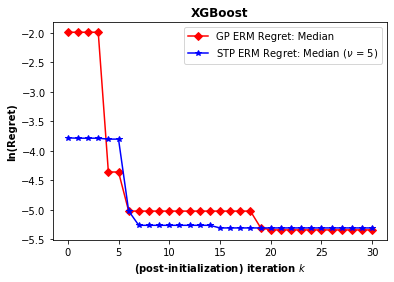

In [77]:
### 8(b). Regret minimisation plot: GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_9, label = 'GP ERM Regret: Median', marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_12, label = 'STP ERM Regret: Median ' r'($\nu$' ' = {})'.format(df1), marker = '*', color = 'Blue')

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


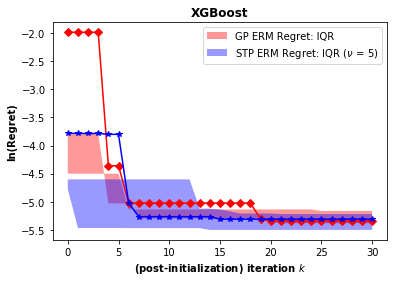

In [78]:
### 8(c). Regret minimisation plot: IQR GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_9, marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_12, marker = '*', color = 'Blue')

xstar = np.arange(0, 31, step=1)
plt.fill_between(xstar, train_regret_gp_10, train_regret_gp_12, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, train_regret_stp_df1_16, train_regret_stp_df1_8, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


In [325]:
# Iteration1 :

slice1 = 0

gp1 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp1 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]

lower_gp1, median_gp1, upper_gp1, lower_stp1, median_stp1, upper_stp1


(-4.209830241257138,
 -4.537426461675017,
 -4.913043412021056,
 -4.209830241257138,
 -4.537426461675017,
 -4.913043412021056)

In [326]:
# Iteration11 :

slice11 = 10

gp11 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp11 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]

lower_gp11, median_gp11, upper_gp11, lower_stp11, median_stp11, upper_stp11


(-4.9625897021081435,
 -5.165856793799957,
 -5.344989113198684,
 -4.628479230876084,
 -5.204438920825461,
 -5.3704622566126305)

In [327]:
# Iteration21 :

slice21 = 20

gp21 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp21 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]

lower_gp21, median_gp21, upper_gp21, lower_stp21, median_stp21, upper_stp21


(-5.015438570012605,
 -5.251874190510547,
 -5.350030893021542,
 -5.165857363117043,
 -5.308440173741311,
 -5.3704622566126305)

In [328]:
# Iteration31 :

slice31 = 30

gp31 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp31 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]

lower_gp31, median_gp31, upper_gp31, lower_stp31, median_stp31, upper_stp31


(-5.163337423675783,
 -5.341974303811602,
 -5.379791996203266,
 -5.216752428162598,
 -5.308440173741311,
 -5.396599052729178)

In [329]:
# Iteration2 :

slice1 = 1

gp2 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp2 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [330]:
# Iteration12 :

slice11 = 11

gp12 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp12 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [331]:
# Iteration22 :

slice21 = 21

gp22 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp22 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [332]:
# Iteration3 :

slice1 = 2

gp3 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp3 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [333]:
# Iteration13 :

slice11 = 12

gp13 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp13 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [334]:
# Iteration23 :

slice21 = 22

gp23 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp23 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [335]:
# Iteration4 :

slice1 = 3

gp4 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp4 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [336]:
# Iteration14 :

slice11 = 13

gp14 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp14 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [337]:
# Iteration24 :

slice21 = 23

gp24 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp24 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [338]:
# Iteration5 :

slice1 = 4

gp5 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp5 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [339]:
# Iteration15 :

slice11 = 14

gp15 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp15 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [340]:
# Iteration25 :

slice21 = 24

gp25 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp25 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [341]:
# Iteration6 :

slice1 = 5

gp6 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp6 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [342]:
# Iteration16 :

slice11 = 15

gp16 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp16 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [343]:
# Iteration26 :

slice21 = 25

gp26 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp26 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [344]:
# Iteration7 :

slice1 = 6

gp7 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp7 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [345]:
# Iteration17 :

slice11 = 16

gp17 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp17 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [346]:
# Iteration27 :

slice21 = 26

gp27 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp27 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [347]:
# Iteration8 :

slice1 = 7

gp8 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp8 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [348]:
# Iteration18 :

slice11 = 17

gp18 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp18 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [349]:
# Iteration28 :

slice21 = 27

gp28 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp28 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [350]:
# Iteration9 :

slice1 = 8

gp9 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp9 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [351]:
# Iteration19 :

slice11 = 18

gp19 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp19 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [352]:
# Iteration29 :

slice21 = 28

gp29 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp29 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [353]:
# Iteration10 :

slice1 = 9

gp10 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp10 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [354]:
# Iteration20 :

slice1 = 19

gp20 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp20 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [355]:
# Iteration30 :

slice1 = 29

gp30 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp30 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [356]:
### 9(a). Summarize Arrays: GPs

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31]


In [357]:
### 9(a). Summarize Arrays: STPs

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31]


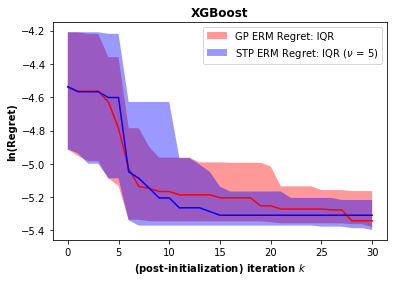

In [359]:
### 10. Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, 31, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
